IMPORTING LIBRARIES

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00


READING DATA

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

#string to date format
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)
df = df.set_index(['Month'])
df.head(5)

<ipython-input-3-7460c1a207f7>:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


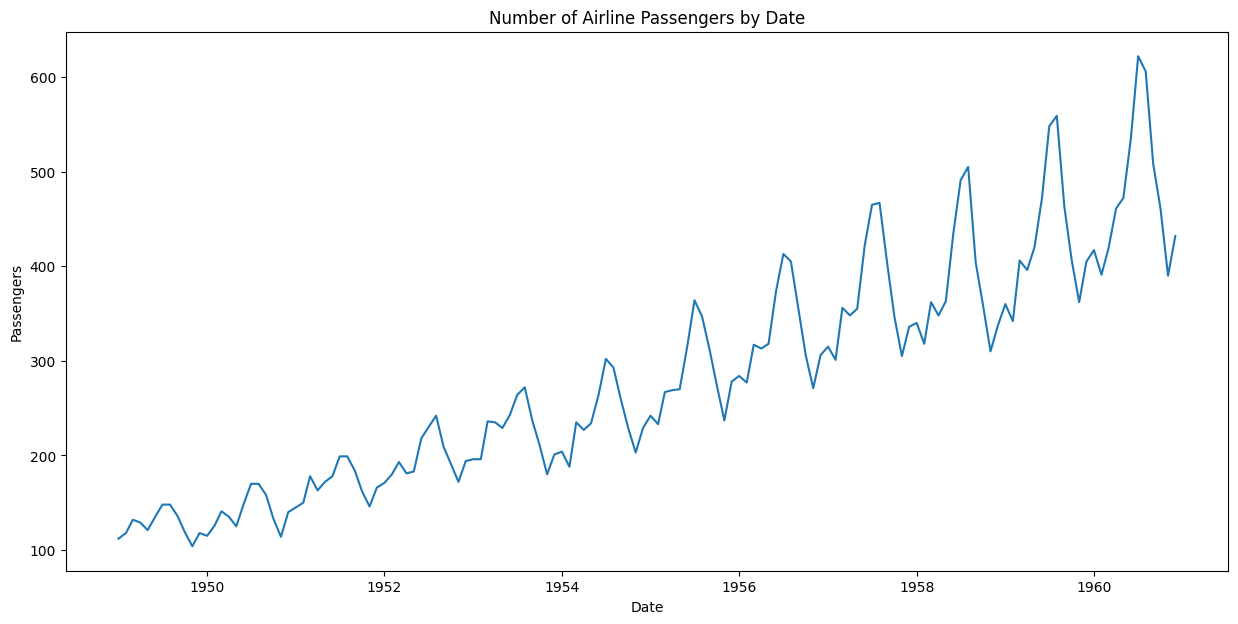

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

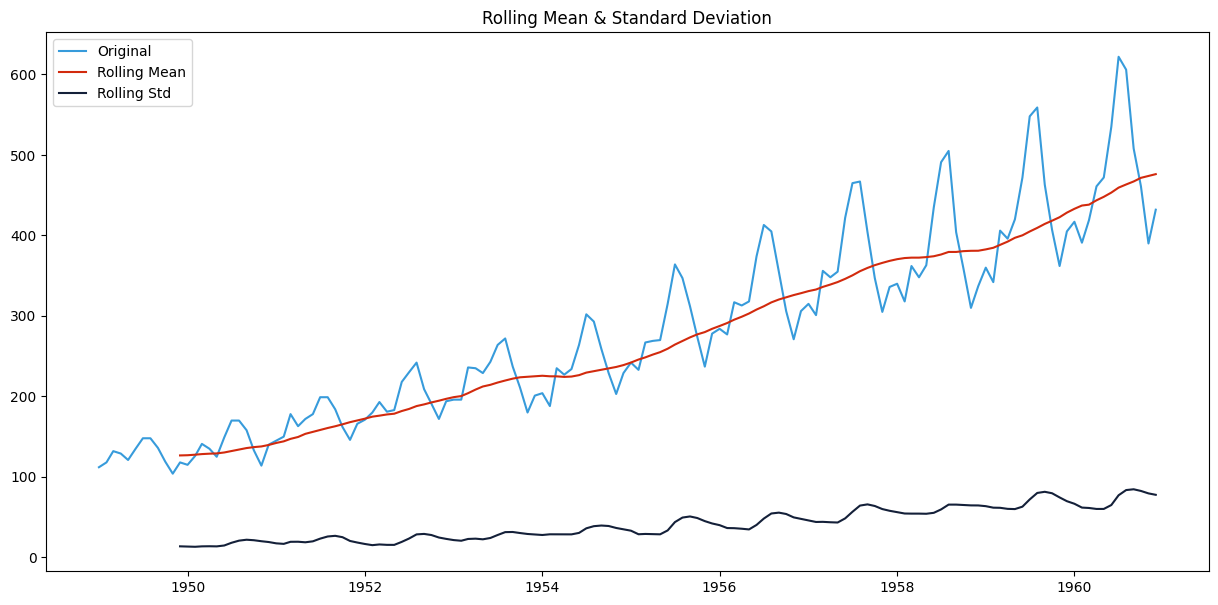

In [ ]:
#Determine rolling statistics
df["rolling_avg"] = df["#Passengers"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["#Passengers"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["#Passengers"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

ADF Test to check stationarity of data

In [ ]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Data is non-stationary

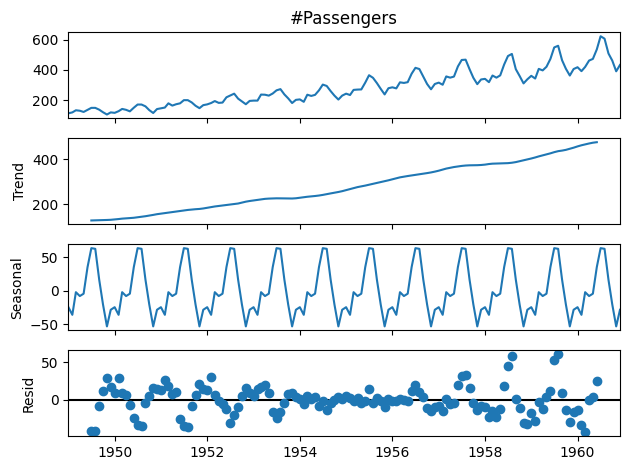

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['#Passengers'], model='additive')
result.plot()
plt.show()

In [ ]:
df['First Difference'] = df['#Passengers'].diff().dropna()

dftest = adfuller(df['First Difference'].dropna(), autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
df['Second Difference'] = df['#Passengers'].diff().diff().dropna()

dftest = adfuller(df['Second Difference'].dropna(), autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Test Statistic                -1.638423e+01
p-value                        2.732892e-29
#Lags Used                     1.100000e+01
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


After Second differencing, data becomes stationary

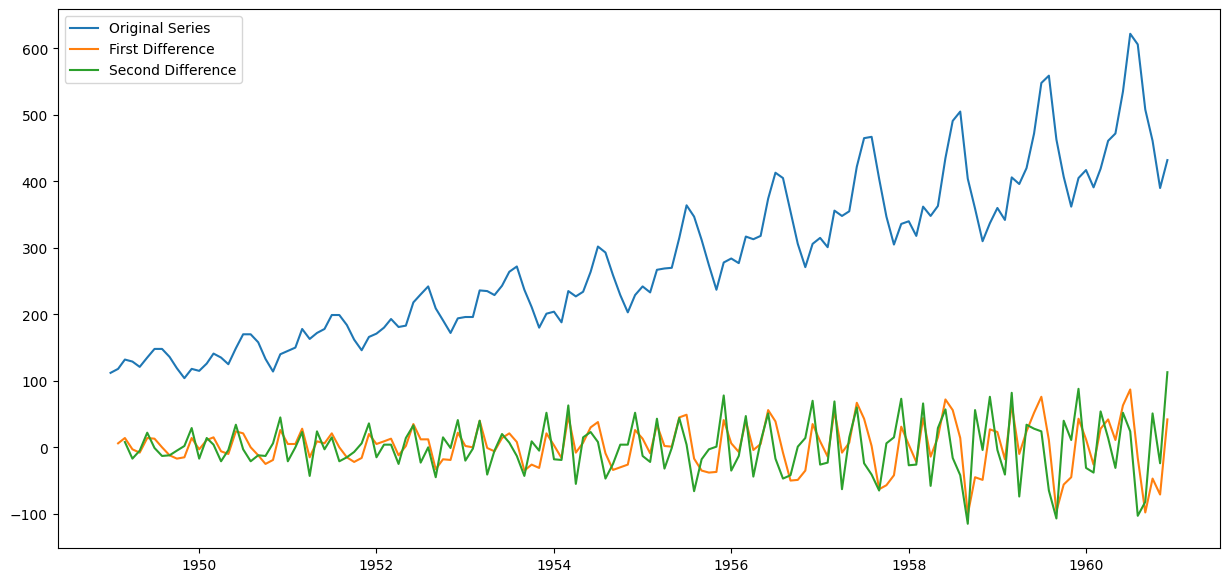

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(df['#Passengers'], label='Original Series')
plt.plot(df['First Difference'], label='First Difference')
plt.plot(df['Second Difference'], label='Second Difference')
plt.legend()
plt.show()

ARIMA Model Fitting

In [ ]:
# Assuming 'df' is your DataFrame and 'Second Difference' is the column name after differencing
# Ensure that you drop any NaN values created during differencing
stationary_series = df['Second Difference'].dropna()

# Fit ARIMA model using auto_arima to automatically find the best parameters
ARIMA_model = pm.auto_arima(
    stationary_series,  # Input series
    start_p=1,
    start_q=1,
    max_p=5,
    max_q=5,
    d=0,  # 'd' is set to 0 since the series is already differenced to stationarity
    seasonal=False,  # Assuming non-seasonal ARIMA
    stepwise=True,  # Perform stepwise search for faster computation
    trace=True  # Display the fitting process
)

# Summary of the model
print(ARIMA_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1450.596, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1447.028, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1440.078, Time=1.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1437.879, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1419.708, Time=0.10 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=1420.111, Time=0.16 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1421.694, Time=0.19 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 3.301 seconds
                               SARIMAX Results                                
Dep. Variable:                    

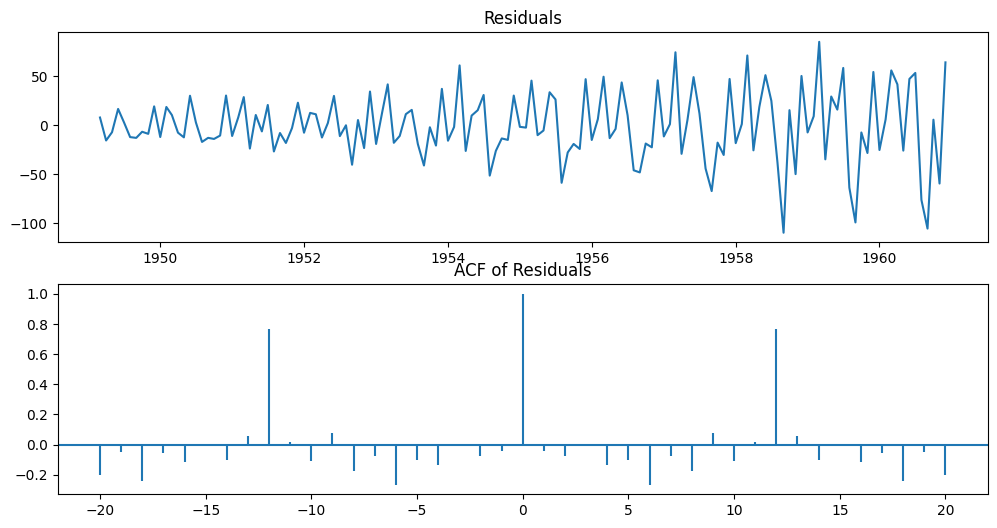

In [ ]:
residuals = ARIMA_model.resid()
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(212)
plt.acorr(residuals, maxlags=20)
plt.title('ACF of Residuals')
plt.show()

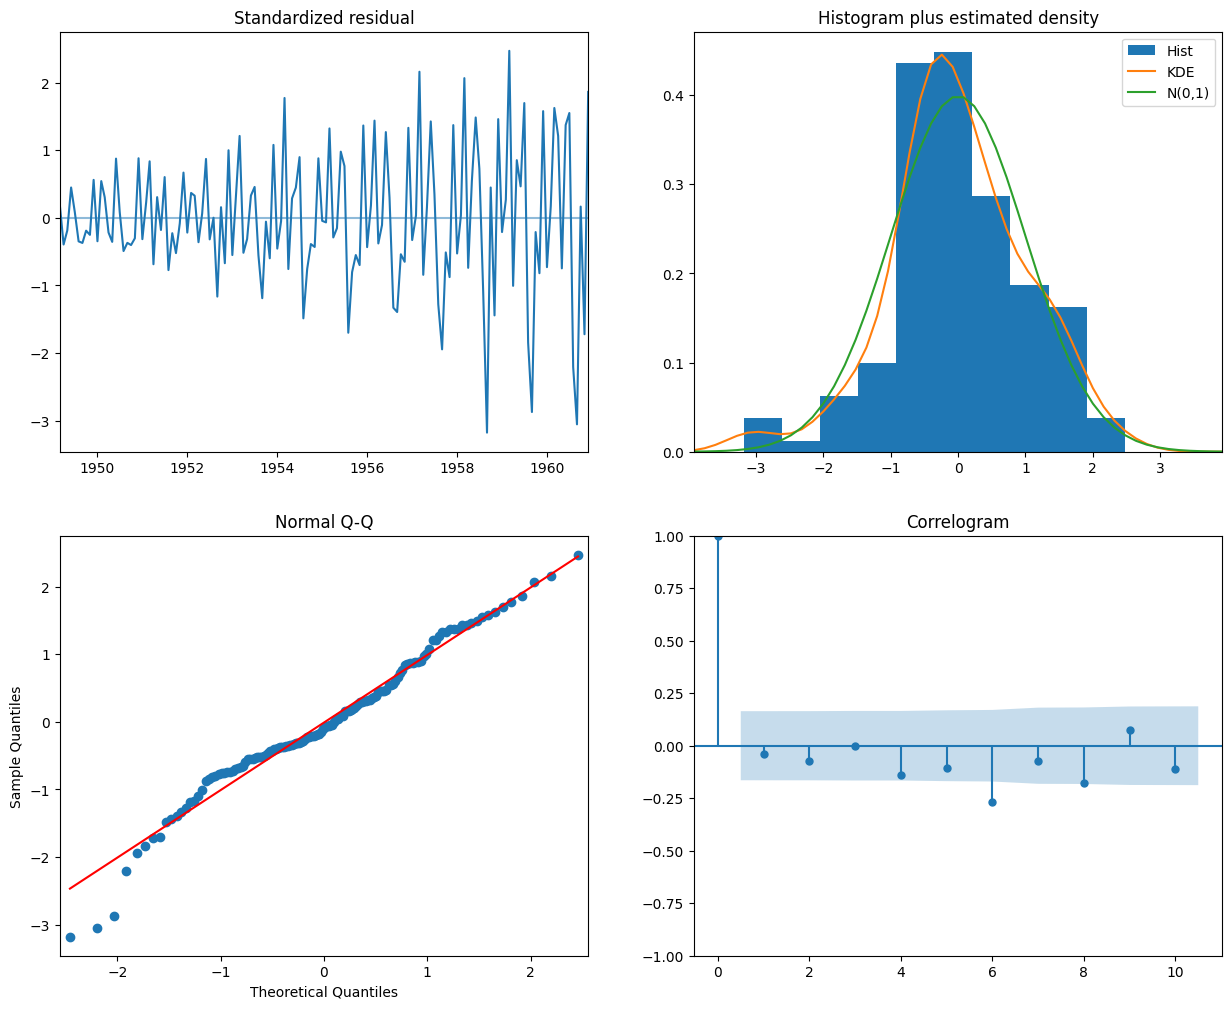

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

Foracast of original data using ARIMA

<ipython-input-38-08067d3e6b40>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_first_diff = [last_first_diff + forecast_diff[0]]
<ipython-input-38-08067d3e6b40>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_first_diff.append(forecast_first_diff[i-1] + forecast_diff[i])


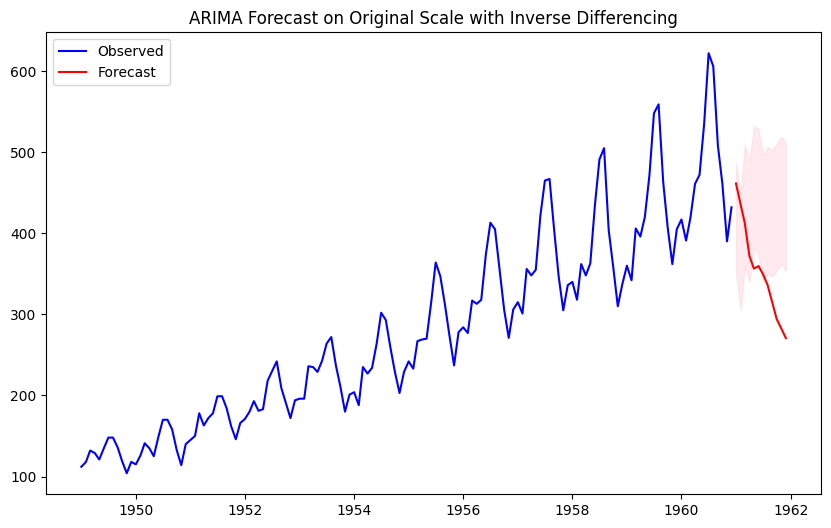

In [ ]:
# Step 1: Forecast future values on the second differenced series
n_periods = 12  # Number of periods to forecast
forecast_diff, conf_int_diff = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)

# Step 2: Reverse the second differencing to get back to the first difference scale
# Retrieve the last first differenced value and last original value
last_first_diff = df['First Difference'].iloc[-1]
last_original = df['#Passengers'].iloc[-1]

# Initialize a list to hold the reverse of second differencing
forecast_first_diff = [last_first_diff + forecast_diff[0]]

# Iteratively calculate the first difference scale from second differencing forecast
for i in range(1, len(forecast_diff)):
    forecast_first_diff.append(forecast_first_diff[i-1] + forecast_diff[i])

# Step 3: Reverse the first differencing to get back to the original scale
# Initialize a list to hold the final forecast values
forecast_original_scale = [last_original + forecast_first_diff[0]]

# Iteratively calculate the original scale forecast
for i in range(1, len(forecast_first_diff)):
    forecast_original_scale.append(forecast_original_scale[i-1] + forecast_first_diff[i])

# Step 4: Convert the forecast to pandas series
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=30), periods=n_periods, freq='M')
forecast_series_original = pd.Series(forecast_original_scale, index=forecast_index)

# Step 5: Plot the original series with forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df['#Passengers'], label='Observed', color='blue')
plt.plot(forecast_series_original, color='red', label='Forecast')

# Plot confidence intervals adjusted back to the original scale
lower_conf_int = conf_int_diff[:, 0] + last_original
upper_conf_int = conf_int_diff[:, 1] + last_original
plt.fill_between(forecast_index, lower_conf_int, upper_conf_int, color='pink', alpha=0.3)

plt.legend()
plt.title('ARIMA Forecast on Original Scale with Inverse Differencing')
plt.show()

SARIMA Model Fitting

In [ ]:
stationary_series = df['Second Difference'].dropna()

# Fit a SARIMA model
SARIMA_model = pm.auto_arima(stationary_series,  # stationary series
                             start_p=1, start_q=1,  # Starting points for p and q
                             test='adf',  # Use ADF test to find optimal 'd'
                             max_p=3, max_q=3,  # Maximum values for p and q
                             m=12,  # Seasonal period (12 for monthly data if it's yearly seasonality)
                             start_P=0, start_Q=0,  # Starting points for P and Q
                             max_P=2, max_Q=2,  # Maximum values for P and Q
                             seasonal=True,  # Enable seasonal differencing
                             d=None,  # Let the model determine the differencing term
                             D=1,  # Order of seasonal differencing
                             trace=True,  # Print output for each step
                             error_action='ignore',  # Ignore errors and continue
                             suppress_warnings=True,  # Suppress warnings
                             stepwise=True)  # Use stepwise algorithm

# Print model summary
print(SARIMA_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1151.749, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1081.078, Time=0.63 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1149.749, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1080.172, Time=0.09 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1081.216, Time=0.33 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1082.590, Time=0.72 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=1065.616, Time=0.28 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1064.615, Time=0.45 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1064.592, Time=1.38 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.07 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=1065.071, Time=1.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1082.556, Time=1.45 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept

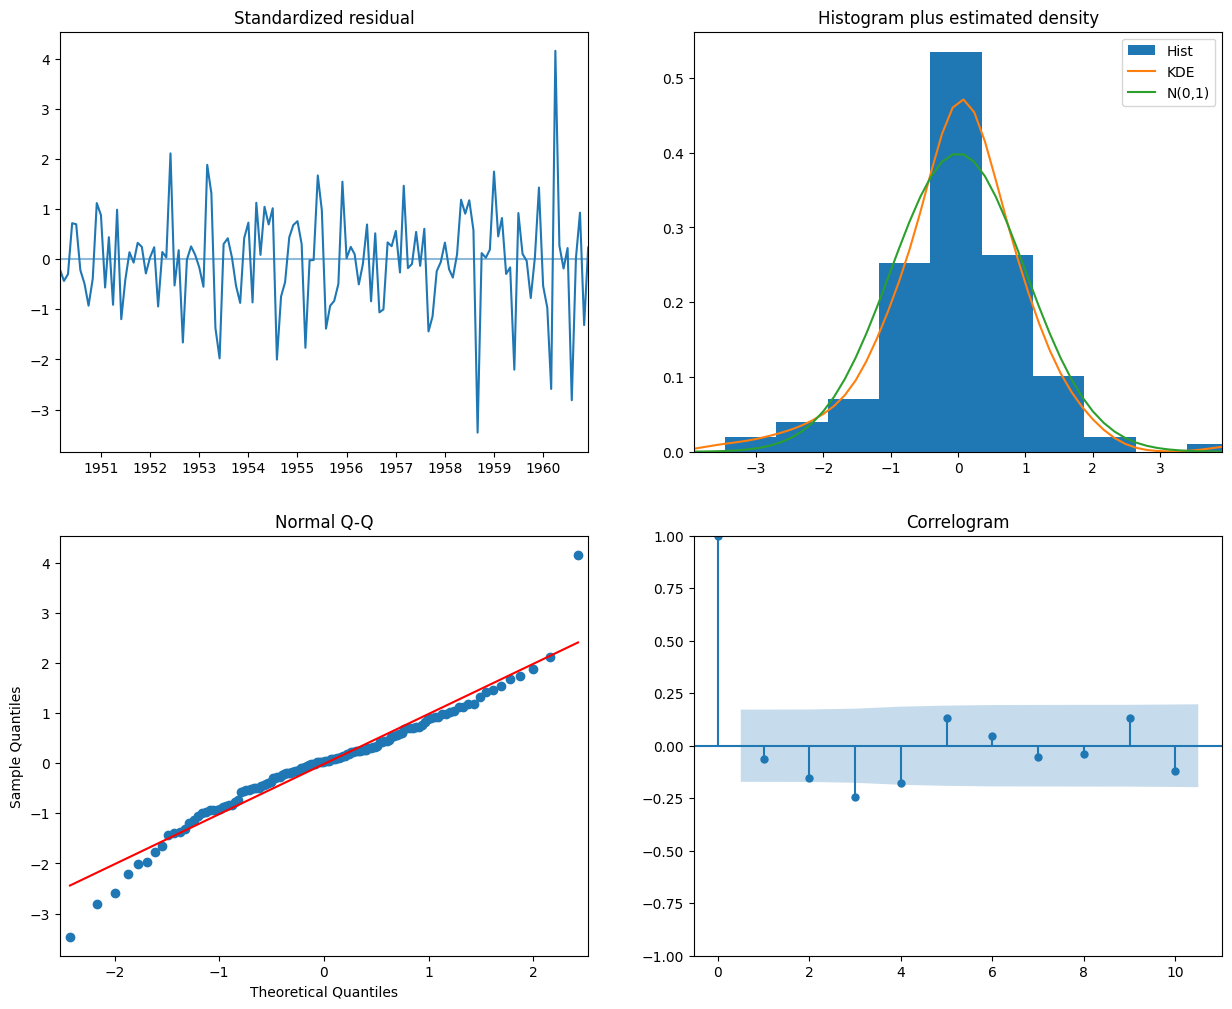

In [ ]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

Forcast using Sarima

<ipython-input-22-d02b1cf2cfab>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_first_diff = [last_first_diff + forecast_diff[0]]
<ipython-input-22-d02b1cf2cfab>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_first_diff.append(forecast_first_diff[i-1] + forecast_diff[i])


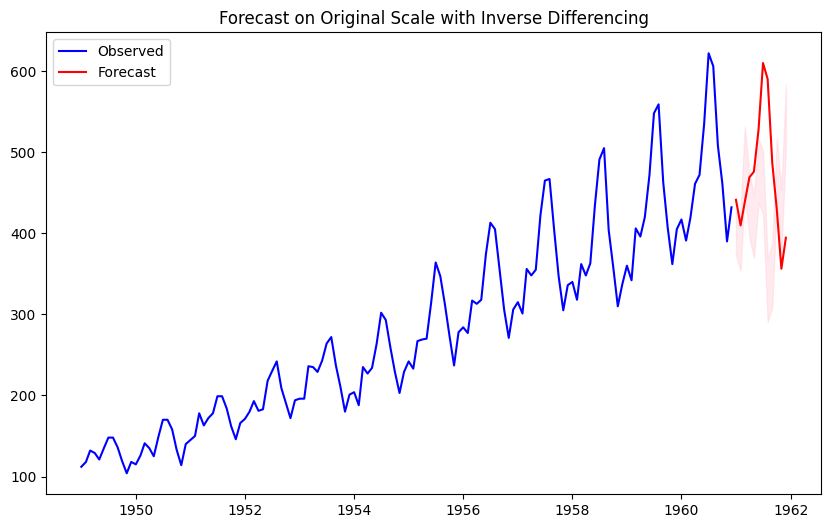

In [ ]:
# Step 1: Forecast future values on the second differenced series
n_periods = 12  # Number of periods to forecast
forecast_diff, conf_int_diff = SARIMA_model.predict(n_periods=n_periods, return_conf_int=True)

# Step 2: Reverse the second differencing to get back to the first difference scale
# Retrieve the last first differenced value and last original value
last_first_diff = df['First Difference'].iloc[-1]
last_original = df['#Passengers'].iloc[-1]

# Initialize a list to hold the reverse of second differencing
forecast_first_diff = [last_first_diff + forecast_diff[0]]

# Iteratively calculate the first difference scale from second differencing forecast
for i in range(1, len(forecast_diff)):
    forecast_first_diff.append(forecast_first_diff[i-1] + forecast_diff[i])

# Step 3: Reverse the first differencing to get back to the original scale
# Initialize a list to hold the final forecast values
forecast_original_scale = [last_original + forecast_first_diff[0]]

# Iteratively calculate the original scale forecast
for i in range(1, len(forecast_first_diff)):
    forecast_original_scale.append(forecast_original_scale[i-1] + forecast_first_diff[i])

# Step 4: Convert the forecast to pandas series
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=30), periods=n_periods, freq='M')
forecast_series_original = pd.Series(forecast_original_scale, index=forecast_index)

# Step 5: Plot the original series with forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df['#Passengers'], label='Observed', color='blue')
plt.plot(forecast_series_original, color='red', label='Forecast')

# Plot confidence intervals adjusted back to the original scale
lower_conf_int = conf_int_diff[:, 0] + last_original
upper_conf_int = conf_int_diff[:, 1] + last_original
plt.fill_between(forecast_index, lower_conf_int, upper_conf_int, color='pink', alpha=0.3)

plt.legend()
plt.title('Forecast on Original Scale with Inverse Differencing')
plt.show()

Adding 'Month' as Exogenous variable and SARIMAX Model Fitting

In [ ]:
#adding exogenous variable
df['month_index'] = df.index.month

# Assuming df['Second Difference'] is your stationary time series after second differencing

stationary_series = df['Second Difference'].dropna()

# Fit the SARIMAX model using auto_arima
SARIMAX_model = pm.auto_arima(
    stationary_series,     # The differenced stationary series
    start_p=1,                   # Starting AR order
    start_q=1,                   # Starting MA order
    test='adf',                  # Use ADF test to find optimal differencing
    max_p=3,                     # Maximum AR order
    max_q=3,                     # Maximum MA order
    m=12,                        # Seasonal period (e.g., 12 for monthly data)
    start_P=0,                   # Starting seasonal AR order
    seasonal=True,               # Enable seasonal differencing
    d=None,                      # Let auto_arima determine the optimal 'd'
    D=1,                         # Seasonal differencing order
    trace=True,                  # Enable verbose output to see the progress
    error_action='ignore',       # Ignore errors and continue searching
    suppress_warnings=True,      # Suppress warnings
    stepwise=True                # Use stepwise approach to search
)

# Print the summary of the fitted model
print(SARIMAX_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1151.749, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1081.078, Time=0.38 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1149.749, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1080.172, Time=0.10 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1081.216, Time=0.29 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1082.590, Time=0.75 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=1065.616, Time=0.22 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1064.615, Time=0.41 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1064.592, Time=1.30 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.04 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=1065.071, Time=2.36 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1082.556, Time=2.00 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept

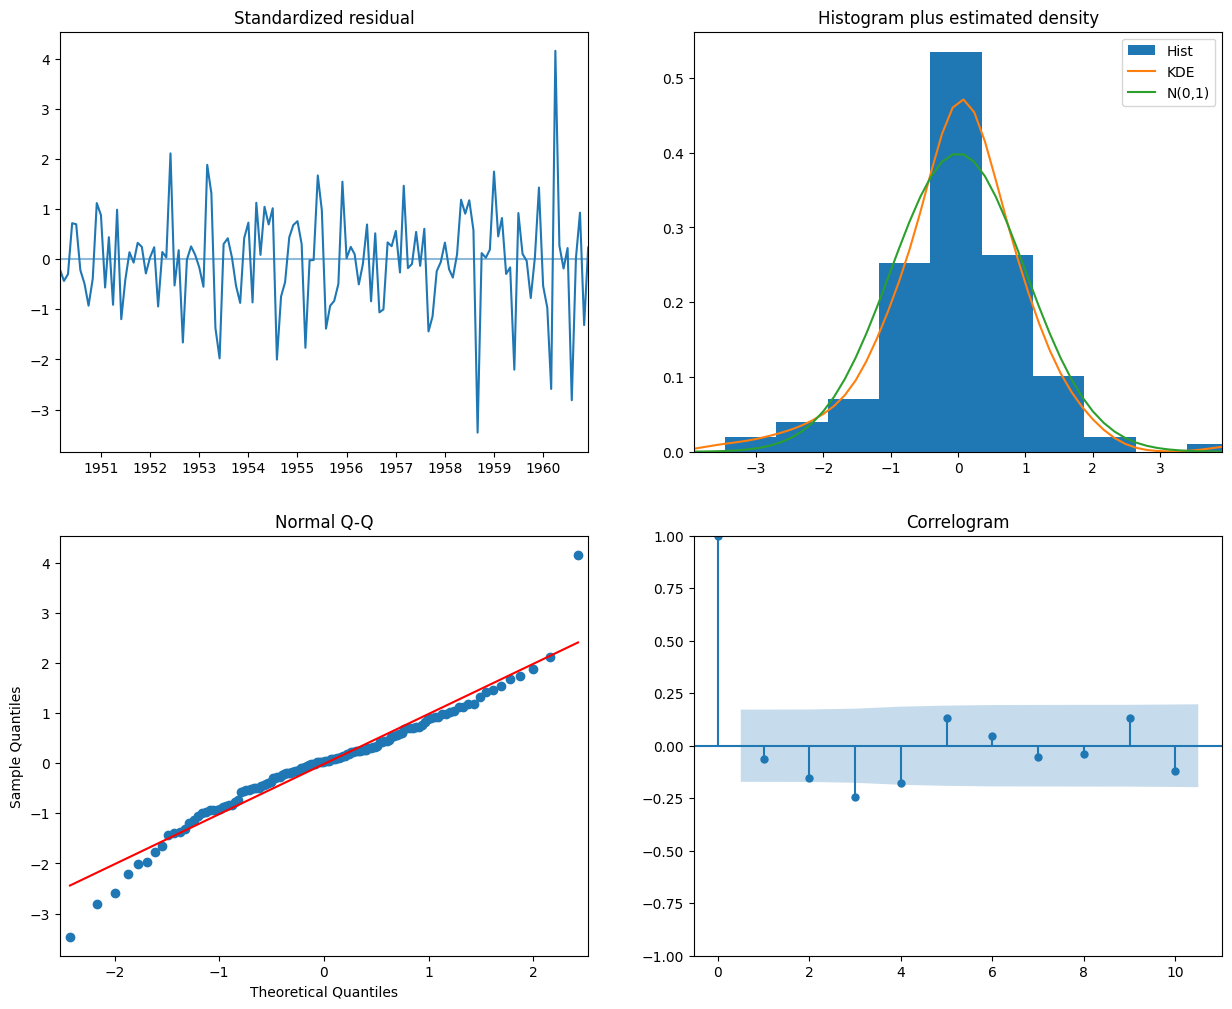

In [ ]:
SARIMAX_model.plot_diagnostics(figsize=(15,12))
plt.show()

<ipython-input-42-6039e2e1116d>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_first_diff = [last_first_diff + forecast_diff[0]]
<ipython-input-42-6039e2e1116d>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_first_diff.append(forecast_first_diff[i-1] + forecast_diff[i])


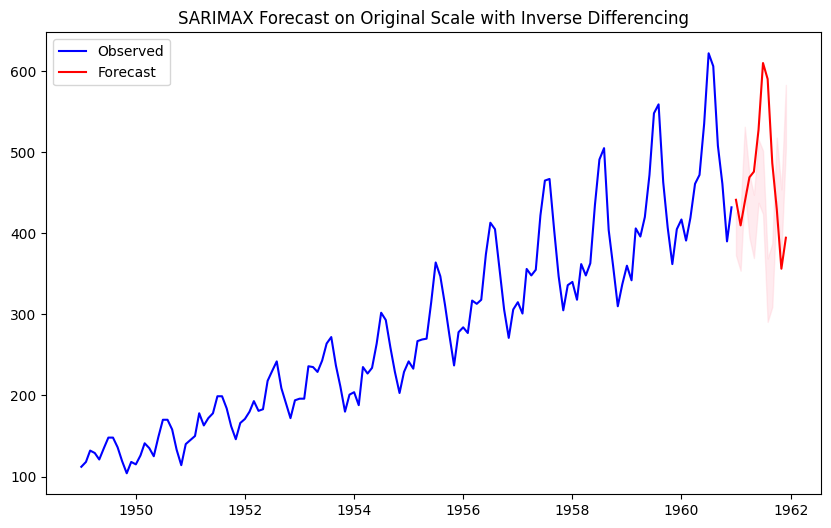

In [ ]:
# Step 1: Forecast future values on the second differenced series
n_periods = 12  # Number of periods to forecast
forecast_diff, conf_int_diff = SARIMAX_model.predict(n_periods=n_periods, return_conf_int=True)

# Step 2: Reverse the second differencing to get back to the first difference scale
# Retrieve the last first differenced value and last original value
last_first_diff = df['First Difference'].iloc[-1]
last_original = df['#Passengers'].iloc[-1]

# Initialize a list to hold the reverse of second differencing
forecast_first_diff = [last_first_diff + forecast_diff[0]]

# Iteratively calculate the first difference scale from second differencing forecast
for i in range(1, len(forecast_diff)):
    forecast_first_diff.append(forecast_first_diff[i-1] + forecast_diff[i])

# Step 3: Reverse the first differencing to get back to the original scale
# Initialize a list to hold the final forecast values
forecast_original_scale = [last_original + forecast_first_diff[0]]

# Iteratively calculate the original scale forecast
for i in range(1, len(forecast_first_diff)):
    forecast_original_scale.append(forecast_original_scale[i-1] + forecast_first_diff[i])

# Step 4: Convert the forecast to pandas series
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=30), periods=n_periods, freq='M')
forecast_series_original = pd.Series(forecast_original_scale, index=forecast_index)

# Step 5: Plot the original series with forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df['#Passengers'], label='Observed', color='blue')
plt.plot(forecast_series_original, color='red', label='Forecast')

# Plot confidence intervals adjusted back to the original scale
lower_conf_int = conf_int_diff[:, 0] + last_original
upper_conf_int = conf_int_diff[:, 1] + last_original
plt.fill_between(forecast_index, lower_conf_int, upper_conf_int, color='pink', alpha=0.3)

plt.legend()
plt.title('SARIMAX Forecast on Original Scale with Inverse Differencing')
plt.show()